In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
import sys
import torch
from tqdm import tnrange

sys.path.insert(0, '..')
from adaptis.inference.adaptis_sampling import get_panoptic_segmentation
from adaptis.inference.prediction_model import AdaptISPrediction

device = torch.device('cuda:0')

### Init dataset

In [2]:
from adaptis.data.custom import CustomDataset

dataset_path = '../../custom_dataset_small'
dataset = CustomDataset(dataset_path, split='test', with_segmentation=True)
dataset.num_classes

6

### Visualize training example

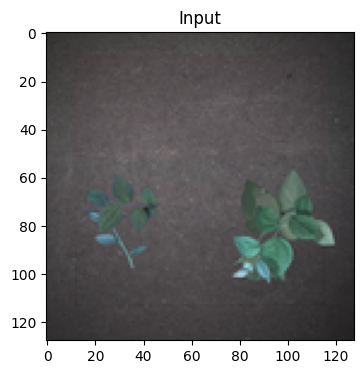

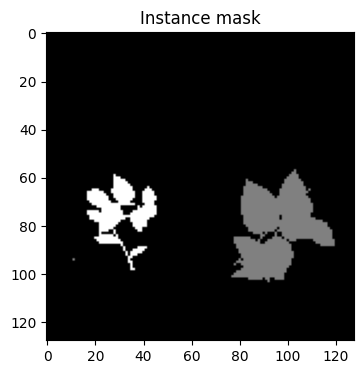

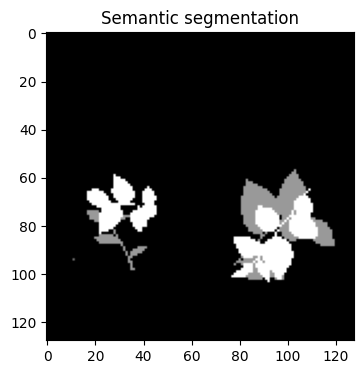

In [3]:
sample = dataset.get_sample(33)

sample['instances_info']

image = cv2.cvtColor(sample['image'], cv2.COLOR_RGB2BGR)
plt.figure(figsize=(4, 4))
plt.title("Input")
plt.imshow(image)

image = sample['instances_mask']
plt.figure(figsize=(4, 4))
plt.title("Instance mask")
plt.imshow(image, cmap='gray')

image = sample['semantic_segmentation']
plt.figure(figsize=(4, 4))
plt.title("Semantic segmentation")
plt.imshow(image, cmap='gray')


### Load model

In [4]:
from adaptis.model.toy.models import get_unet_model

model = get_unet_model(num_classes=5, norm_layer=torch.nn.BatchNorm2d, with_proposals=True)
pmodel = AdaptISPrediction(model, dataset, device)

weights_path = '../experiments/custom/000/checkpoints/last_checkpoint.params'
pmodel.load_parameters(weights_path)

### Define evaluation function

In [5]:
from adaptis.coco.panoptic_metric import PQStat, pq_compute, print_pq_stat


def test_model(pmodel, dataset,
               sampling_algorithm, sampling_params,
               use_flip=False, cut_radius=-1):
    pq_stat = PQStat()
    categories = dataset._generate_coco_categories()
    categories = {x['id']: x for x in categories}

    for indx in tnrange(len(dataset)):
        sample = dataset.get_sample(indx)
        pred = get_panoptic_segmentation(pmodel, sample['image'],
                                         sampling_algorithm=sampling_algorithm,
                                         use_flip=use_flip, cut_radius=cut_radius, **sampling_params)
        
        
        coco_sample = dataset.convert_to_coco_format(sample)
        pred = dataset.convert_to_coco_format(pred)

        pq_stat = pq_compute(pq_stat, pred, coco_sample, categories)
    
    print_pq_stat(pq_stat, categories)

### Test proposals-based point sampling

In [6]:
proposals_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'fl_prob': 0.10,
    'fl_eps': 0.003,
    'fl_blur': 2,
    'max_iters': 100
}

test_model(pmodel, dataset,
           sampling_algorithm='proposals',
           sampling_params=proposals_sampling_params,
           use_flip=False)

/tmp/ipykernel_3308912/3711189657.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for indx in tnrange(len(dataset)):


  0%|          | 0/90 [00:00<?, ?it/s]

          |     PQ      SQ      RQ     N
--------------------------------------
All       |  20.38   29.03   21.77     6
Things    |   4.58   14.95    6.12     5
Stuff     |  99.39   99.39  100.00     1


In [7]:
proposals_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'fl_prob': 0.10,
    'fl_eps': 0.003,
    'fl_blur': 2,
    'max_iters': 100
}

test_model(pmodel, dataset,
           sampling_algorithm='proposals',
           sampling_params=proposals_sampling_params,
           use_flip=True)

/tmp/ipykernel_3308912/3711189657.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for indx in tnrange(len(dataset)):


  0%|          | 0/90 [00:00<?, ?it/s]

          |     PQ      SQ      RQ     N
--------------------------------------
All       |  20.16   29.44   21.32     6
Things    |   4.31   15.45    5.58     5
Stuff     |  99.40   99.40  100.00     1


### Test random sampling

In [8]:
random_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'num_candidates': 7,
    'num_iters': 40
}

test_model(pmodel, dataset,
           sampling_algorithm='random', sampling_params=random_sampling_params,
           use_flip=False)

/tmp/ipykernel_3308912/3711189657.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for indx in tnrange(len(dataset)):


  0%|          | 0/90 [00:00<?, ?it/s]

          |     PQ      SQ      RQ     N
--------------------------------------
All       |  20.00   29.08   21.24     6
Things    |   4.12   15.01    5.49     5
Stuff     |  99.40   99.40  100.00     1


In [9]:
random_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'num_candidates': 7,
    'num_iters': 40
}

test_model(pmodel, dataset,
           sampling_algorithm='random', sampling_params=random_sampling_params,
           use_flip=True)

/tmp/ipykernel_3308912/3711189657.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for indx in tnrange(len(dataset)):


  0%|          | 0/90 [00:00<?, ?it/s]

          |     PQ      SQ      RQ     N
--------------------------------------
All       |  19.59   29.05   20.70     6
Things    |   3.63   14.97    4.84     5
Stuff     |  99.41   99.41  100.00     1


### Results visualization

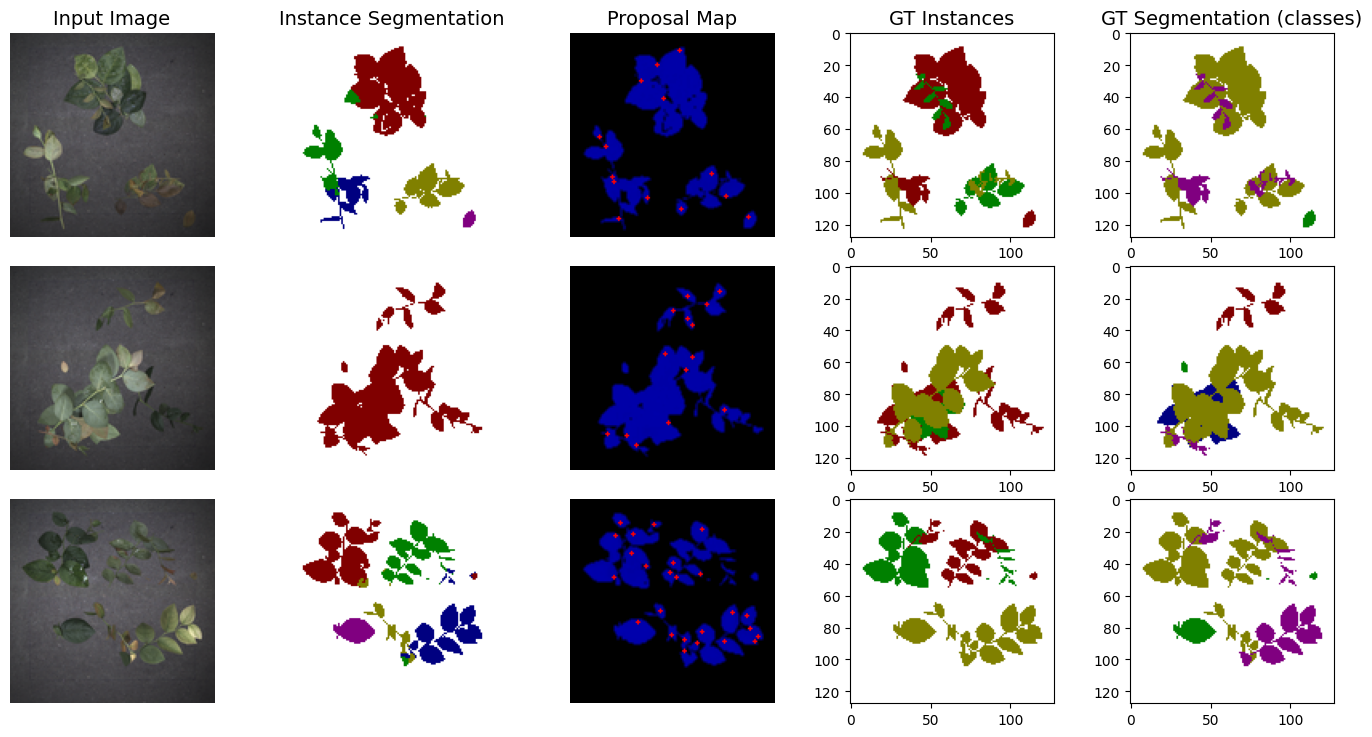

In [10]:
from adaptis.utils.vis import visualize_instances, visualize_proposals


proposals_sampling_params = {
    'thresh1': 0.5,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'fl_prob': 0.10,
    'fl_eps': 0.003,
    'fl_blur': 2,
    'max_iters': 100
}

vis_samples = [15, 25, 42]


fig, ax = plt.subplots(nrows=len(vis_samples), ncols=5, figsize=(14,7))
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

for row_indx, sample_indx in enumerate(vis_samples):
    sample = dataset.get_sample(sample_indx)
    pred = get_panoptic_segmentation(pmodel, sample['image'],
                                 sampling_algorithm='proposals',
                                 use_flip=True, **proposals_sampling_params)
    
    for i in range(3):
        ax[row_indx, i].axis('off')

    if row_indx == 0:
        ax[row_indx, 0].set_title('Input Image', fontsize=14)
        ax[row_indx, 1].set_title('Instance Segmentation', fontsize=14)
        ax[row_indx, 2].set_title('Proposal Map', fontsize=14)
        ax[row_indx, 3].set_title('GT Instances', fontsize=14)
        ax[row_indx, 4].set_title('GT Segmentation (classes)', fontsize=14)
    ax[row_indx, 0].imshow(sample['image'])
    ax[row_indx, 1].imshow(visualize_instances(pred['instances_mask']))
    ax[row_indx, 2].imshow(visualize_proposals(pred['proposals_info']))
    ax[row_indx, 3].imshow(visualize_instances(sample['instances_mask']))
    ax[row_indx, 4].imshow(visualize_instances(sample['semantic_segmentation']))

### Test challenging samples

In [11]:
# from adaptis.utils.vis import visualize_instances, visualize_proposals

# dense_sampling_params = {
#     'thresh1': 0.75,
#     'thresh2': 0.50,
#     'ithresh': 0.3,
#     'fl_prob': 0.10,
#     'fl_eps': 0.003,
#     'fl_blur': 2,
#     'max_iters': 1000,
#     'cut_radius': 48
# }

# sample_image = cv2.imread('../images/toy_v2_samples/00000_250_rgb.png')[:, :, ::-1].copy()
# plt.figure(figsize=(8, 8))
# plt.imshow(sample_image)

# pred = get_panoptic_segmentation(pmodel, sample_image,
#                                  sampling_algorithm='proposals',
#                                  use_flip=True, **dense_sampling_params)

# plt.figure(figsize=(8,8))
# plt.imshow(visualize_instances(pred['instances_mask'],
#                                boundaries_color=(150, 150, 150), boundaries_alpha=0.8))

# plt.figure(figsize=(8,8))
# plt.imshow(visualize_proposals(pred['proposals_info']))